In [56]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import svd
import numpy as np
import plotly.graph_objects as go
import seaborn as sns
from scipy.stats import ttest_ind, probplot

In [57]:
file_path = 'diabetes.csv'
df = pd.read_csv(file_path)

display(df.head())

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [58]:
# Replace 0's with NaN

df['Glucose'] = df['Glucose'].replace(0, np.nan) # 5 observation med 0
df['BloodPressure'] = df['BloodPressure'].replace(0, np.nan) # 35 m 0
df['SkinThickness'] = df['SkinThickness'].replace(0, np.nan) # 234 m 0
df['Insulin'] = df['Insulin'].replace(0, np.nan) #374 observationer med 0
df['BMI'] = df['BMI'].replace(0, np.nan) # 11 med 0
df['Age'] = df['Age'].replace(0, np.nan) # 0 m 0
df['DiabetesPedigreeFunction'] = df['DiabetesPedigreeFunction'].replace(0,np.nan)

# Remove NaN rows in data
df_no_nan = df.dropna()

colnames_temp = [col for col in df_no_nan.columns]

# Calculate the mean and standard deviation for each column
means = df_no_nan.mean()
stds = df_no_nan.std()

# Define a filtering condition for each column
# Each feature must be within 4 standard deviations from the mean
# How many stds?
std_threshold = 4
conditions = (df_no_nan < (means - std_threshold * stds)) | (df_no_nan > (means + std_threshold * stds))

# Any row that should be removed will have at least one True in the conditions DataFrame
rows_to_remove = conditions.any(axis=1)

# Filter out the rows that meet the condition
df_no_nan = df_no_nan[~rows_to_remove]


In [59]:
df_no_nan.to_csv('diabetes_removed_nan.csv', index=False)

new_df = pd.read_csv("diabetes_removed_nan.csv")

display(new_df.head())
len(new_df)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
1,3,78.0,50.0,32.0,88.0,31.0,0.248,26,1
2,2,197.0,70.0,45.0,543.0,30.5,0.158,53,1
3,5,166.0,72.0,19.0,175.0,25.8,0.587,51,1
4,0,118.0,84.0,47.0,230.0,45.8,0.551,31,1


383

In [60]:
# Standardize data
# Which coloumns to drop:
drop_coloumns = ['Outcome']#, 'DiabetesPedigreeFunction'

features = [col for col in df.columns if col not in [kol for kol in drop_coloumns]]

x = new_df.loc[:, features].values
x = StandardScaler().fit_transform(x)
new_x = pd.DataFrame(x, columns=features).assign(Outcome=new_df['Outcome'])
new_x.to_csv('diabetes_data_transformed.csv')
len(x.T)

8

Pregnancies
Low outliers: 0 High outliers: 21 Tot: 21 Percent: 0.055


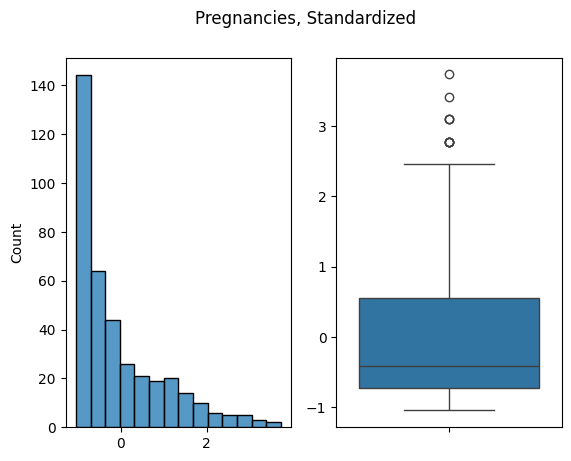

Glucose
Low outliers: 0 High outliers: 14 Tot: 14 Percent: 0.037


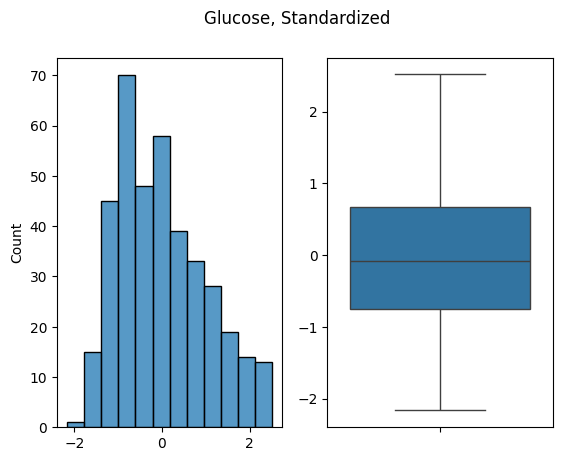

BloodPressure
Low outliers: 7 High outliers: 7 Tot: 14 Percent: 0.037


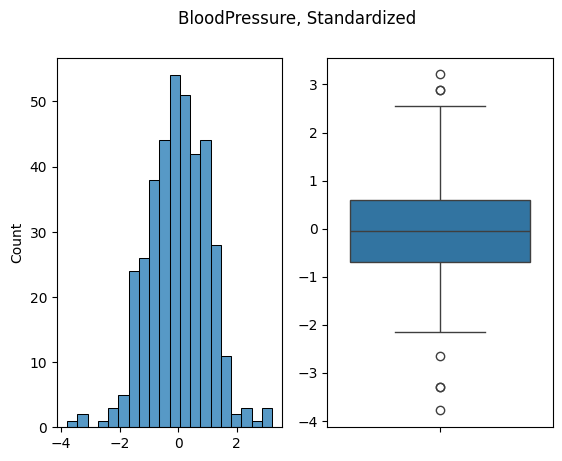

SkinThickness
Low outliers: 0 High outliers: 4 Tot: 4 Percent: 0.01


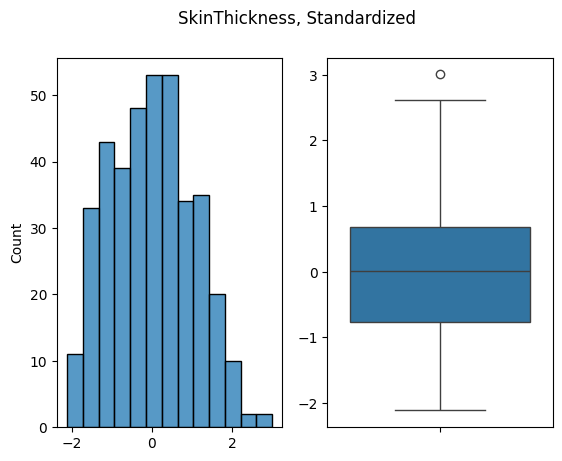

Insulin
Low outliers: 0 High outliers: 33 Tot: 33 Percent: 0.086


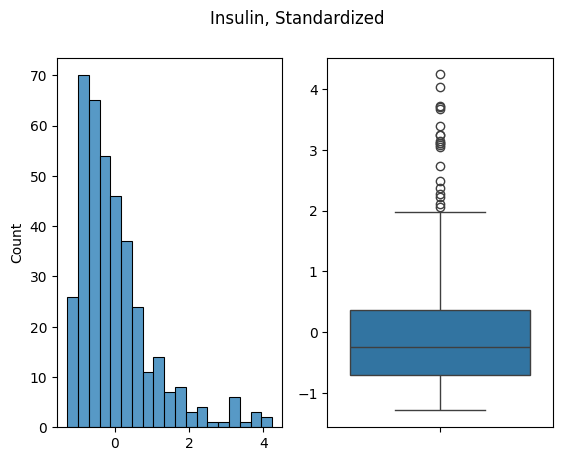

BMI
Low outliers: 7 High outliers: 15 Tot: 22 Percent: 0.057


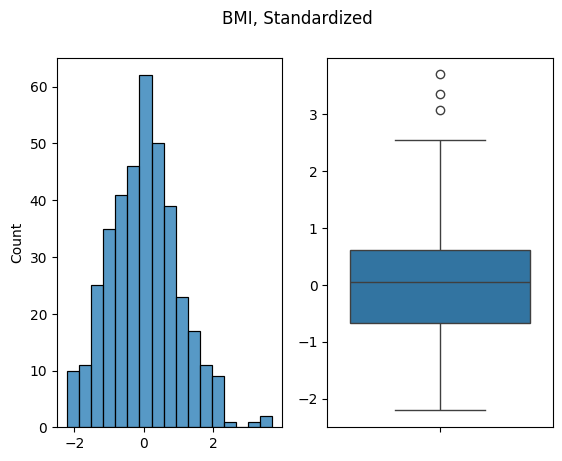

DiabetesPedigreeFunction
Low outliers: 0 High outliers: 20 Tot: 20 Percent: 0.052


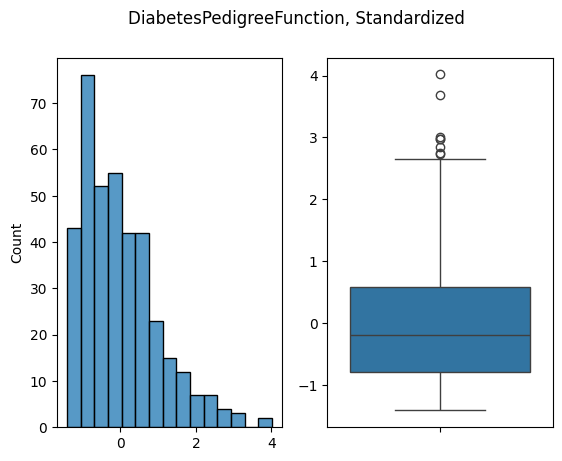

Age
Low outliers: 0 High outliers: 28 Tot: 28 Percent: 0.073


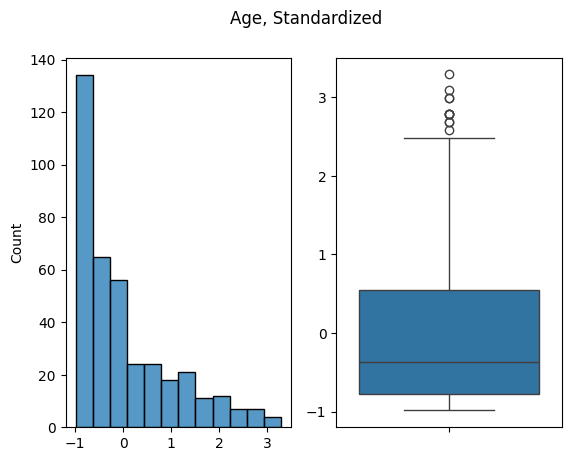

In [61]:
from scipy.stats import iqr

data_details_df = pd.DataFrame({
    'Attribute' : features,
    'Min' : [min(new_df[features[i]]) for i in range(len(x.T))]    ,
    'Max' : [max(new_df[features[i]]) for i in range(len(x.T))]    ,
    'Mean' : [np.mean(new_df[features[i]]) for i in range(len(x.T))]    ,
    'Median' : [np.median(new_df[features[i]]) for i in range(len(x.T))]  ,
    'Variance' : [np.var(new_df[features[i]]) for i in range(len(x.T))]   ,
    'Q1' : [np.quantile(new_df[features[i]],0.25) for i in range(len(x.T))] ,
    'Q3' : [np.quantile(new_df[features[i]],0.75) for i in range(len(x.T))] 
})

# table = plt.table(cellText=data_details_df.values.T,
#                   rowLabels=data_details_df.keys().T,
#                   colLabels=df.columns.T,
#                   loc='center')
# print(data_details_df.to_latex())

for i, att in enumerate(x.T):
    print(features[i])
    # print('min', min(new_df[features[i]]), '\nmax', max(new_df[features[i]]), '\nmean', np.mean(new_df[features[i]])    
    #       , '\nmedian',  np.median(new_df[features[i]]), '\nvar', np.var(new_df[features[i]]))
    iqr_data = iqr(att)
    q1, q3 = np.quantile(att,0.25), np.quantile(att,0.75) 
    thresh_low, thresh_high = q1 - iqr_data, q3 + iqr_data
    out_low, out_high = 0,0
    for obs in att:
        if obs < thresh_low: out_low +=1
        if obs > thresh_high: out_high += 1
    print('Low outliers:', out_low, 'High outliers:', out_high, 'Tot:', out_high+out_low, 
          'Percent:', np.round((out_low+out_high)/len(att),3))
    fig, axes = plt.subplots(1,2)
    sns.histplot(att, ax=axes.flatten()[0])
    sns.boxplot(att, ax=axes.flatten()[1])
    fig.suptitle(f'{features[i]}, Standardized')
    plt.show()


In [62]:
# PCA

pca = PCA()
principalComponents = pca.fit_transform(x)
len(principalComponents.T)

8

In [63]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = [f'principal component {i+1}' for i in range(len(principalComponents.T))])

[0.32441904 0.18744801 0.1455539  0.1242297  0.09350127 0.05041682
 0.03999719 0.03443407]
0.6574209468570653


8.020942408376964

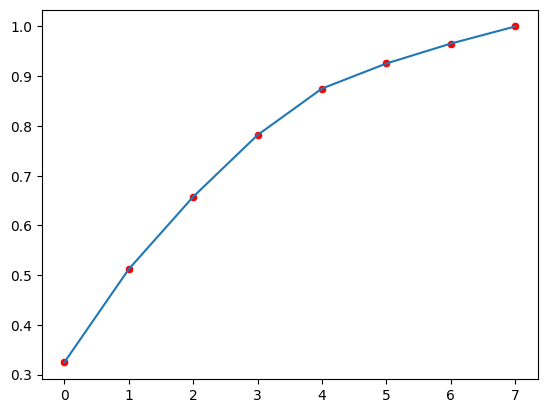

In [64]:
print(pca.explained_variance_ratio_)
plt.figure()
sns.lineplot(np.cumsum(pca.explained_variance_ratio_))
sns.scatterplot(np.cumsum(pca.explained_variance_ratio_), color='r')
print(sum(pca.explained_variance_ratio_[:3]))
sum(pca.explained_variance_)

/var/folders/tc/p_2dw00d5zg0svx3_qj__8tc0000gn/T/ipykernel_49382/1092988937.py:6: UserWarning:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.

/var/folders/tc/p_2dw00d5zg0svx3_qj__8tc0000gn/T/ipykernel_49382/1092988937.py:6: UserWarning:

You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.



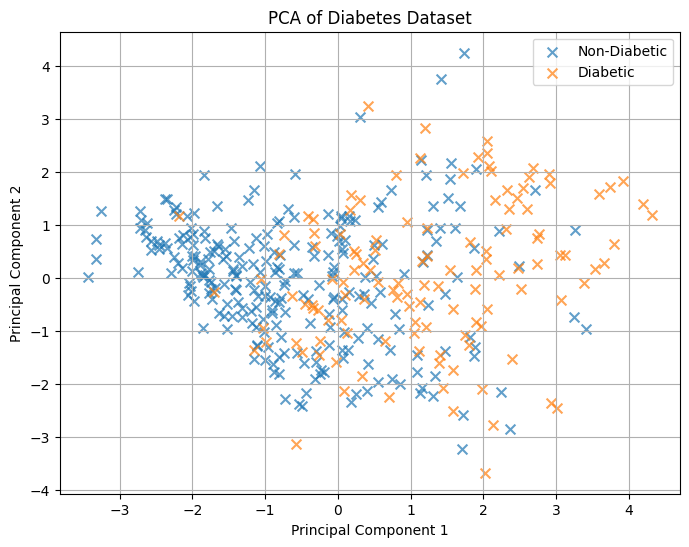

['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


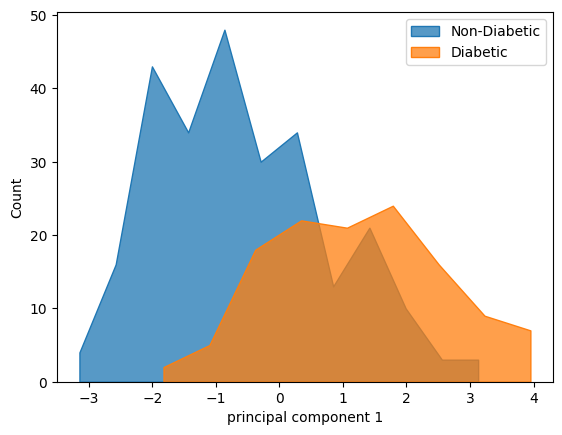

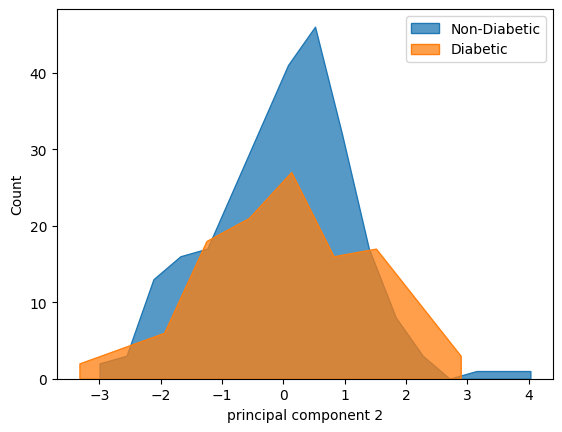

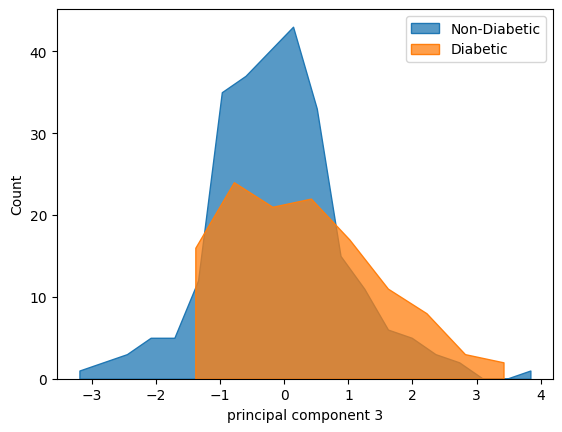

In [65]:
plt.figure(figsize=(8, 6))

colors = sns.color_palette("tab10")
for outcome, color in zip([0, 1], colors):
    indicesToKeep = new_df['Outcome'] == outcome
    plt.scatter(principalDf.loc[indicesToKeep, 'principal component 1'],
                principalDf.loc[indicesToKeep, 'principal component 2'],
                c=color, edgecolor='k', alpha=0.7, s=50, marker='x',
                label=('Non-Diabetic' if outcome == 0 else 'Diabetic'))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Diabetes Dataset')
plt.grid(True)
plt.legend()
plt.show()
print(features)

for i in range(min(len(principalComponents.T), 3)):
    plt.figure()
    sns.histplot(principalDf.loc[new_df['Outcome'] == 0, f'principal component {i+1}'], color=colors[0], 
                label='Non-Diabetic', element='poly')
    sns.histplot(principalDf.loc[new_df['Outcome'] == 1, f'principal component {i+1}'], color=colors[1], 
                label='Diabetic', legend=True,element='poly')
    plt.legend()
    plt.show()

In [66]:
# T-test
conf_level = 0.95
for i in range(min(len(principalComponents.T),3)):
    results = ttest_ind(principalDf.loc[new_df['Outcome'] == 1, f'principal component {i+1}'], 
    principalDf.loc[new_df['Outcome'] == 0, f'principal component {i+1}'])
    print(f'T-test on Diabetic/Non-Diabetic relative to PC{i+1}',
        f'\n{round(100*conf_level)}% CI of difference:', results.confidence_interval(confidence_level=conf_level)[0],
        results.confidence_interval(confidence_level=conf_level)[1],
        '\nP-value:', results.pvalue, 
        '\nNull Hypothesis rejected:', results.pvalue < (1-conf_level), '\n')

T-test on Diabetic/Non-Diabetic relative to PC1 
95% CI of difference: 1.5432698609092423 2.129977046270811 
P-value: 1.506458661461208e-29 
Null Hypothesis rejected: True 

T-test on Diabetic/Non-Diabetic relative to PC2 
95% CI of difference: -0.1682298258430497 0.35867622451146974 
P-value: 0.4777220536685579 
Null Hypothesis rejected: False 

T-test on Diabetic/Non-Diabetic relative to PC3 
95% CI of difference: 0.14911912826694312 0.6074403052567641 
P-value: 0.0012754586660964084 
Null Hypothesis rejected: True 



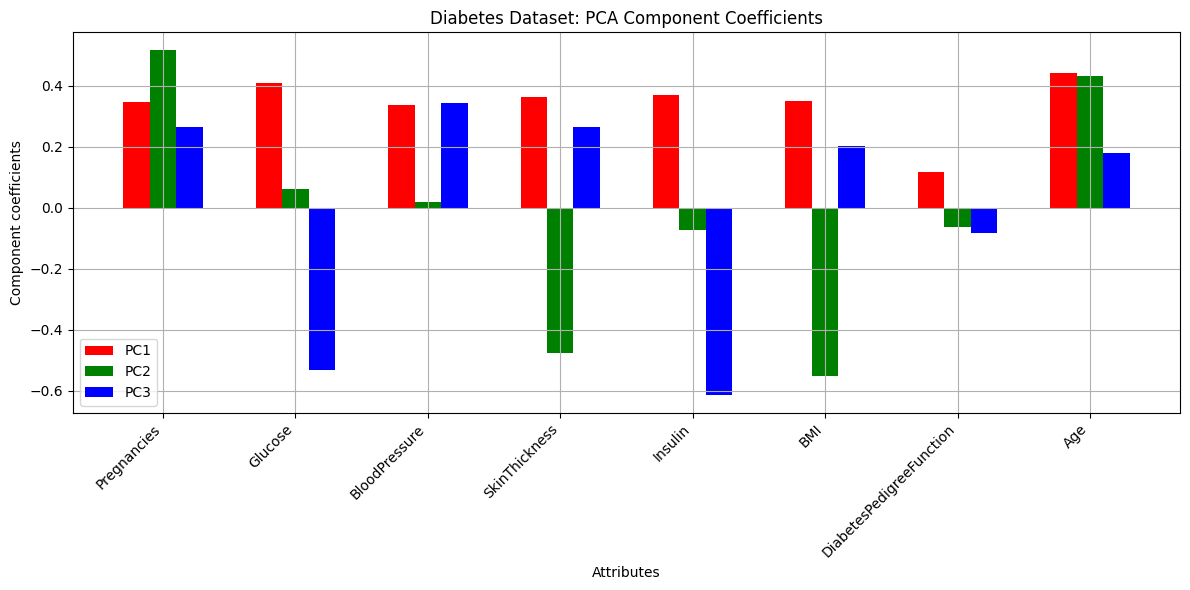

[0.34681597 0.40825362 0.33610619 0.3631525  0.3691082  0.35154482
 0.11603865 0.44148721] 
 [ 0.51891138  0.06081487  0.01778162 -0.47752563 -0.07183686 -0.551366
 -0.06230308  0.43085838] 
 [ 0.26446365 -0.53192627  0.34283257  0.26567115 -0.61577361  0.20157785
 -0.08159983  0.18035741]


['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [67]:
Y = x - np.ones((x.shape[0], 1)) * x.mean(0)
U, S, Vh = svd(Y, full_matrices=False)
V = Vh.T

new_new_df = new_df.drop([col for col in drop_coloumns], axis=1)
attributeNames = list(new_new_df.columns)

pcs = [0, 1, 2]
legendStrs = ["PC" + str(e + 1) for e in pcs]
bw = 0.2
r = np.arange(1, len(attributeNames) + 1)
colors = ["r", "g", "b"]  

plt.figure(figsize=(12, 6))
for i in pcs:
    plt.bar(r + i * bw, V[:, i], width=bw, color=colors[i])
plt.xticks(r + bw, attributeNames, rotation=45, ha="right")
plt.xlabel("Attributes")
plt.ylabel("Component coefficients")
plt.legend(legendStrs)
plt.grid()
plt.title("Diabetes Dataset: PCA Component Coefficients")
plt.tight_layout()  
plt.show()
print(Vh[0],'\n', Vh[1], '\n', Vh[2])
attributeNames

/var/folders/tc/p_2dw00d5zg0svx3_qj__8tc0000gn/T/ipykernel_49382/1931651916.py:8: UserWarning:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Text(0, 0.5, 'PC2')

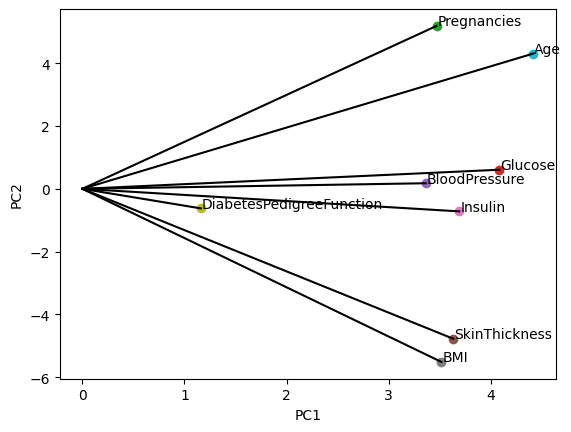

In [68]:
plt.figure()
colors = sns.color_palette("tab10")[2:]  # Skip the first two colors

for i, att in enumerate(attributeNames):
    x = Vh[0,i]*10
    y = Vh[1,i]*10
    color = colors[i % len(colors)]  # Cycle through the colors
    plt.scatter(x, y, marker = 'o', c=color)

    # V this adds the lines V
    plt.plot([0,x], [0, y], color="black")
    # ^ this adds the lines ^

    plt.text(x+0.01, y+0.01, att, fontsize=10)
plt.xlabel('PC1')
plt.ylabel('PC2')

In [69]:
x_values = principalDf['principal component 1']
y_values = principalDf['principal component 2']
z_values = principalDf['principal component 3']
colors = new_df['Outcome'] 

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=x_values,
    y=y_values,
    z=z_values,
    mode='markers',
    marker=dict(
        size=5,
        color=colors,                
        colorscale='Viridis',  
        opacity=0.8
    )
)])


fig.update_layout(
    title='3D PCA Plot',
    scene = dict(
        xaxis_title='Principal Component 1',
        yaxis_title='Principal Component 2',
        zaxis_title='Principal Component 3'
    ),
    margin=dict(r=0, b=0, l=0, t=0)  
)


fig.show()


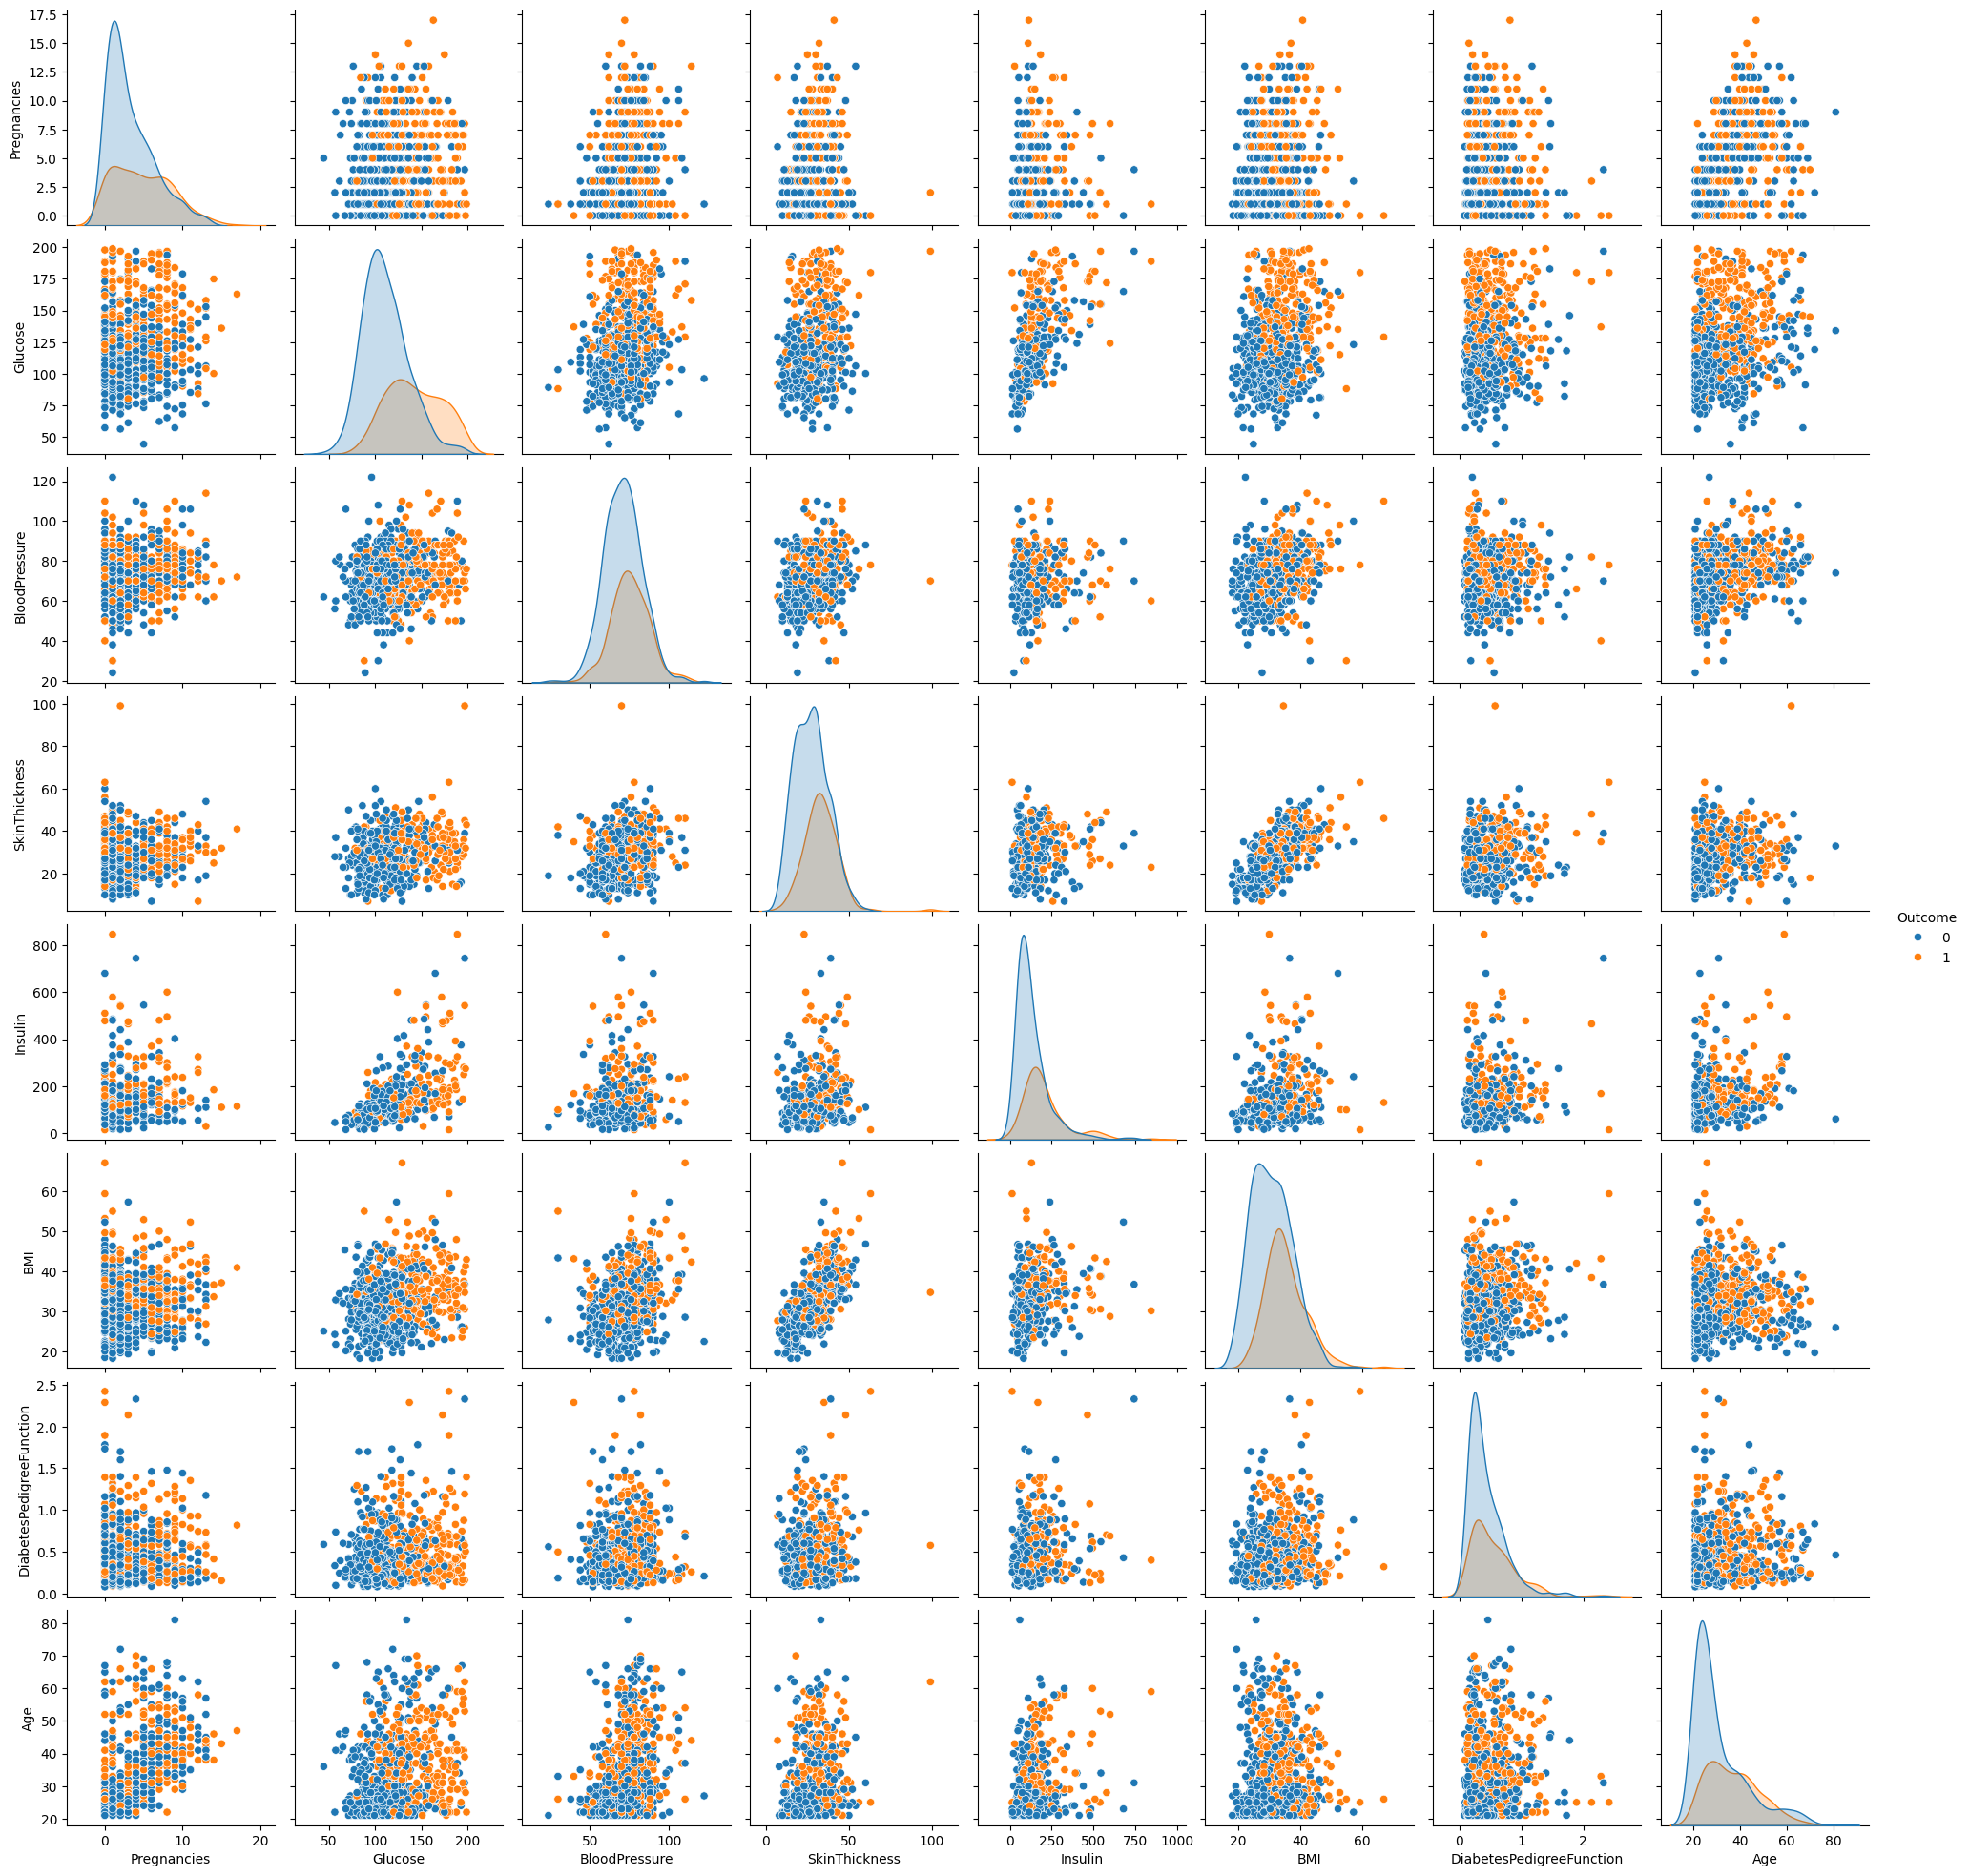

In [70]:
sns.pairplot(df, hue='Outcome')

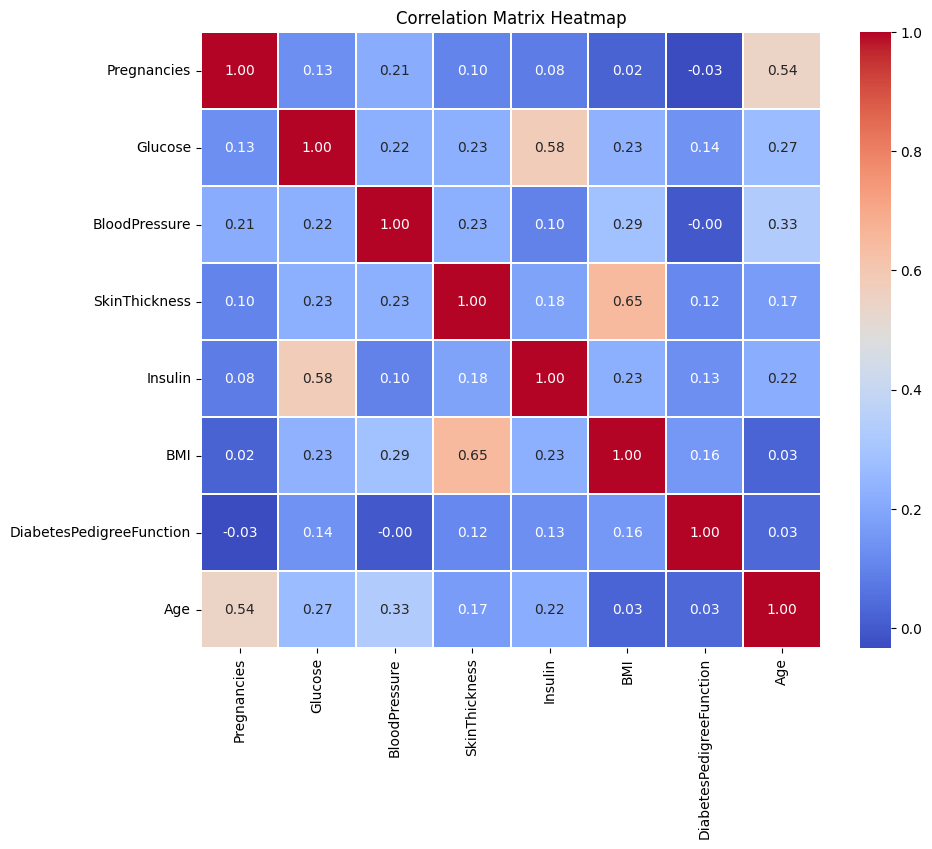

In [71]:
# Calculate the correlation matrix
corr_matrix = df.drop('Outcome', axis=1).corr()

# Generate a heatmap of the correlation matrix
plt.figure(figsize=(10, 8)) # Adjust the size as needed
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.05)
plt.title('Correlation Matrix Heatmap')

# Show the plot
plt.show()

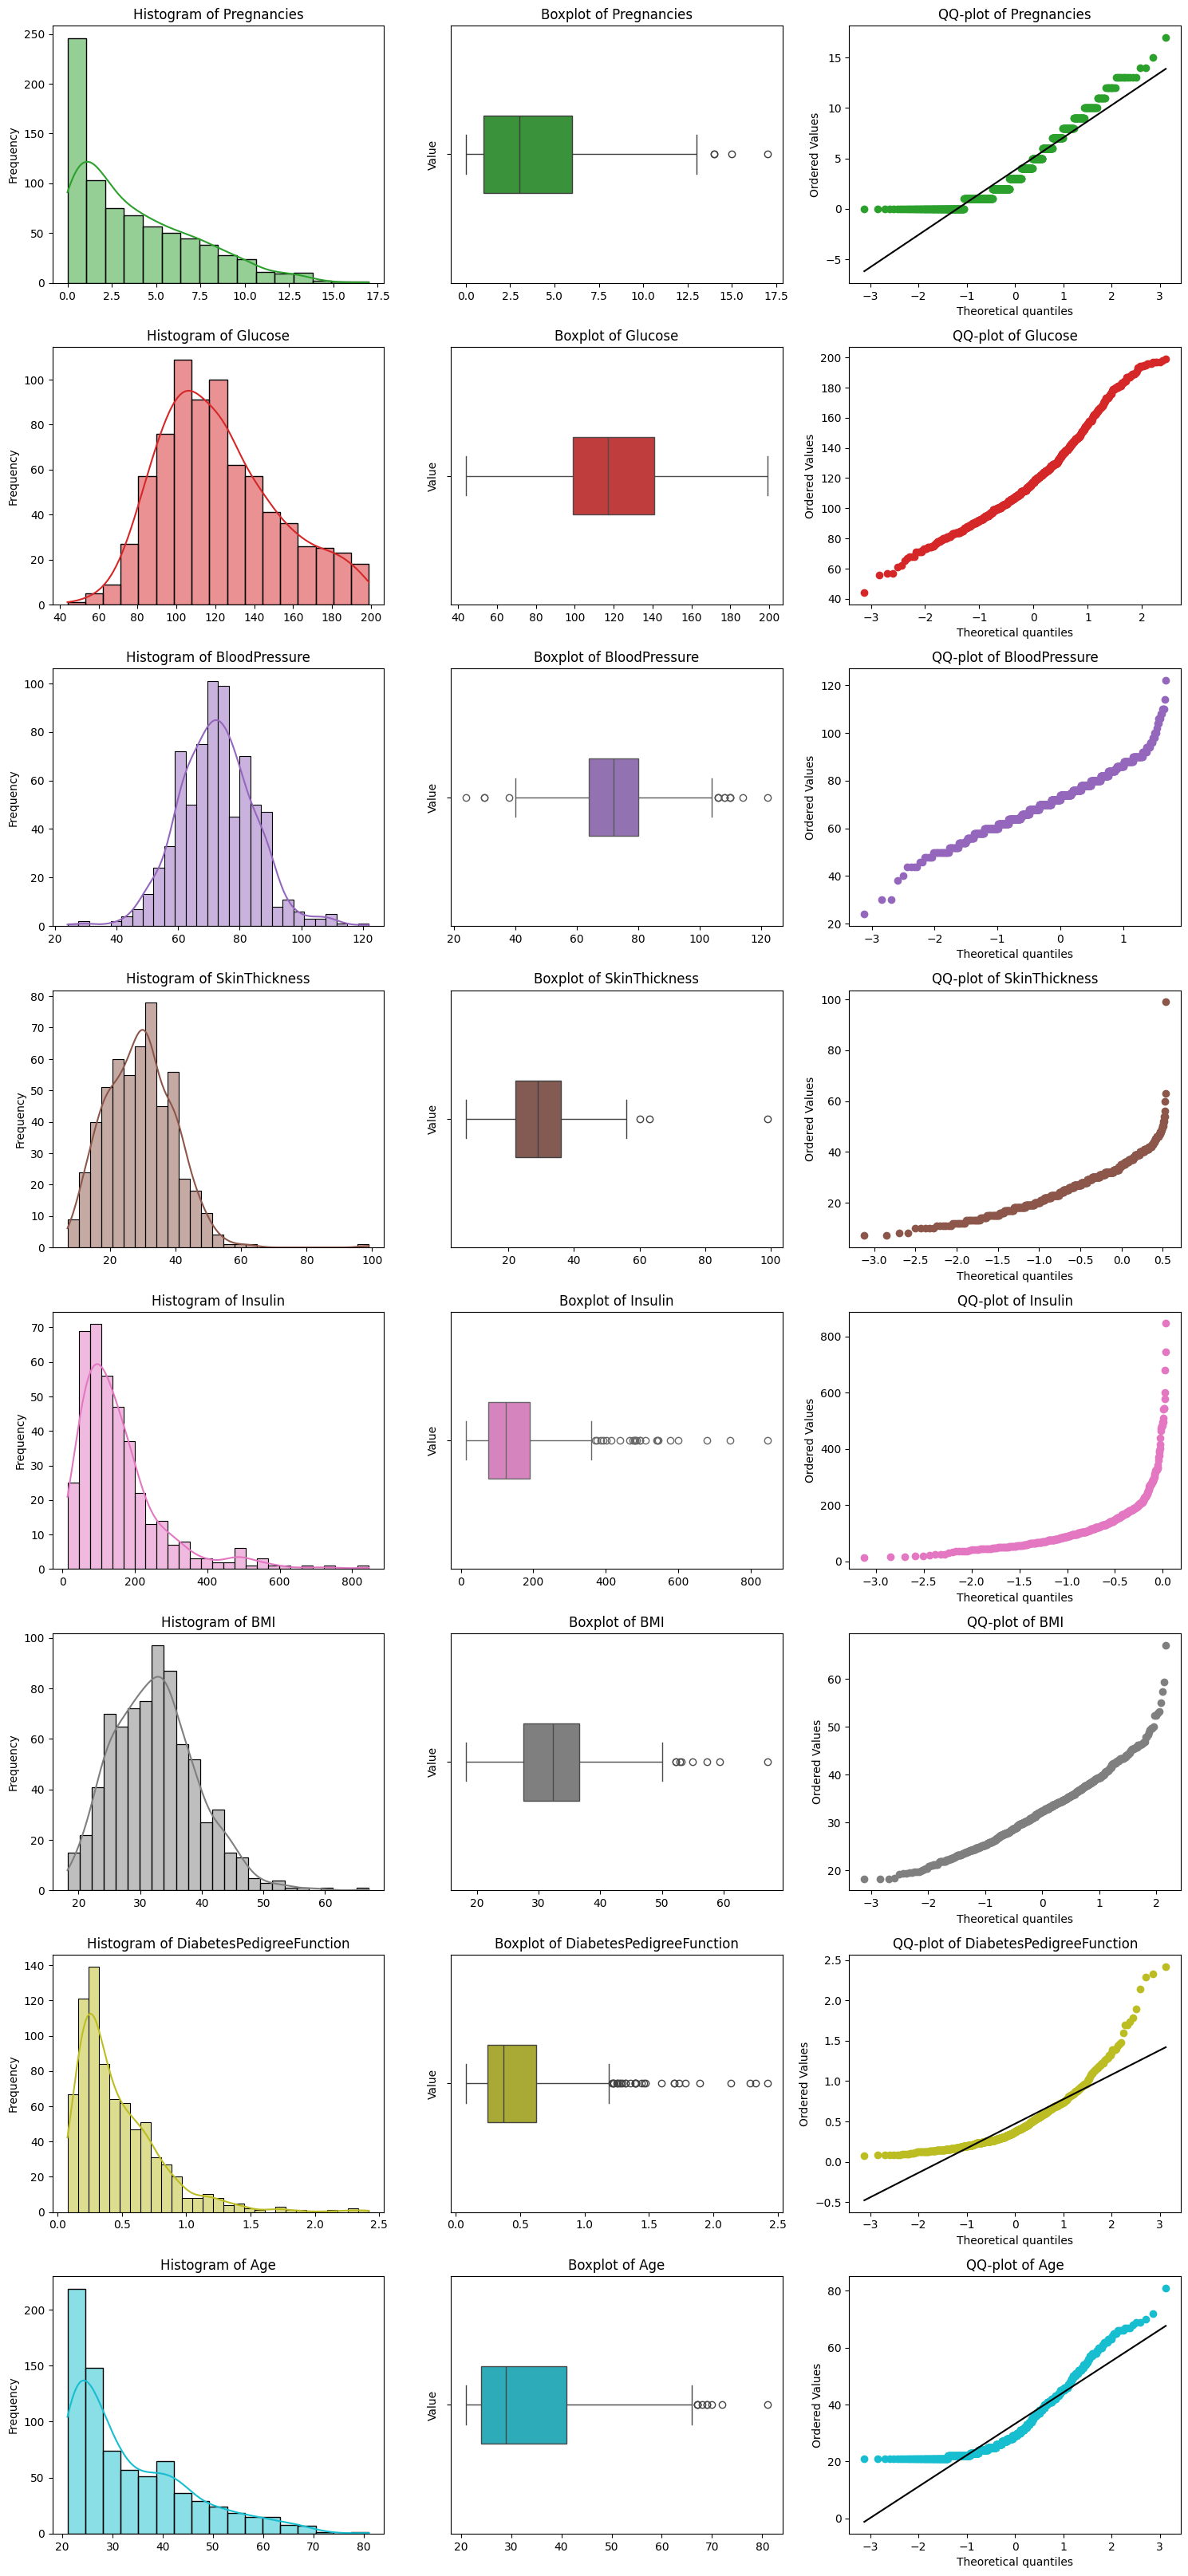

In [80]:
num_variables = len(new_df.columns) - 1  # Subtract 1 for 'Outcome' column

cols = 3  # Set number of columns to 3
rows = int(np.ceil(num_variables / cols)) * 3  # Calculate number of rows based on number of columns

plt.figure(figsize=(5*cols, 4*rows))  

colors = sns.color_palette("tab10")[2:]  # Skip the first two colors

plot_index = 0  # Keep track of current plot index
for i, column in enumerate(new_df.columns):
    if column == 'Outcome':
        continue  # Skip 'Outcome' column

    color = colors[i % len(colors)]  # Cycle through the colors

    ax_hist = plt.subplot(rows, cols, 3*plot_index + 1)  
    sns.histplot(df[column], kde=True, color=color, edgecolor='black', ax=ax_hist)
    ax_hist.set_title(f'Histogram of {column}')
    ax_hist.set_xlabel('')
    ax_hist.set_ylabel('Frequency')

    ax_box = plt.subplot(rows, cols, 3*plot_index + 2) 
    sns.boxplot(x=df[column], ax=ax_box, width=0.3, color=color)
    ax_box.set_title(f'Boxplot of {column}')
    ax_box.set_xlabel('')
    ax_box.set_ylabel('Value')

    ax_qq = plt.subplot(rows, cols, 3*plot_index + 3)
    probplot(df[column], plot=ax_qq)
    ax_qq.get_children()[0].set_color(color)  # Set color of points
    ax_qq.get_children()[1].set_color("black")  # Set color of line
    ax_qq.set_title(f'QQ-plot of {column}')

    plot_index += 1  # Increment plot index

plt.tight_layout() 
plt.show()